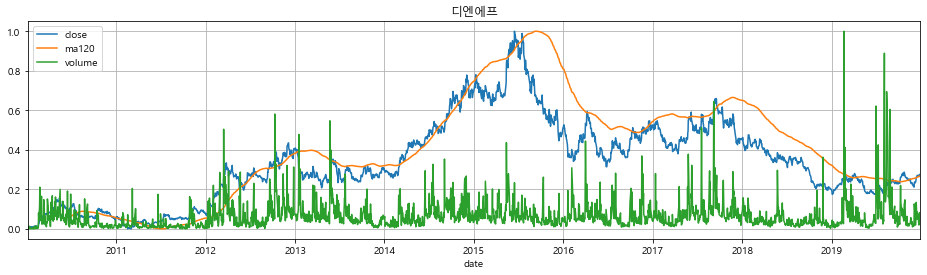

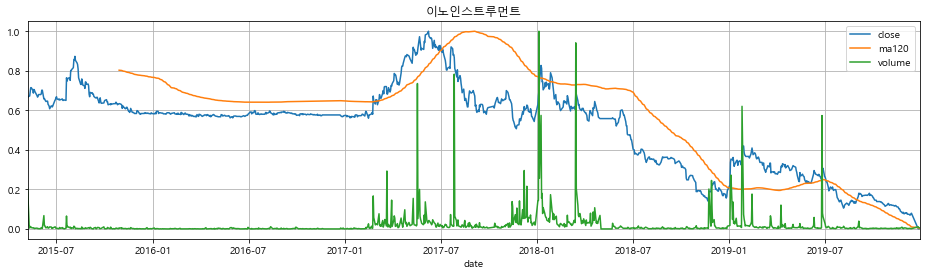

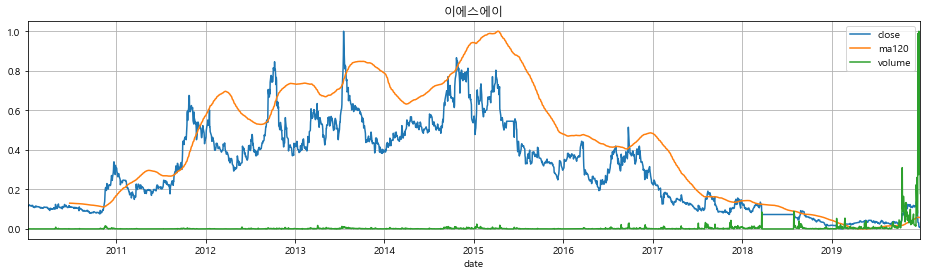

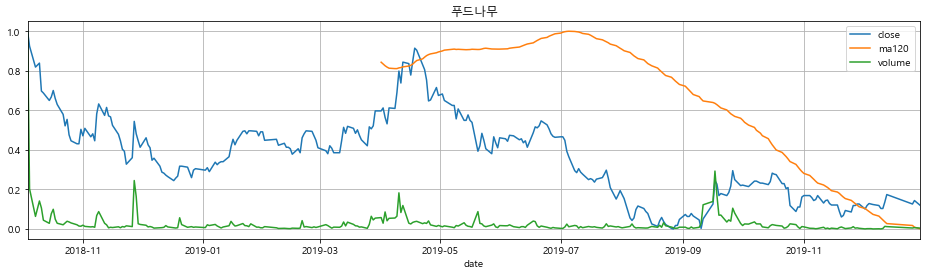

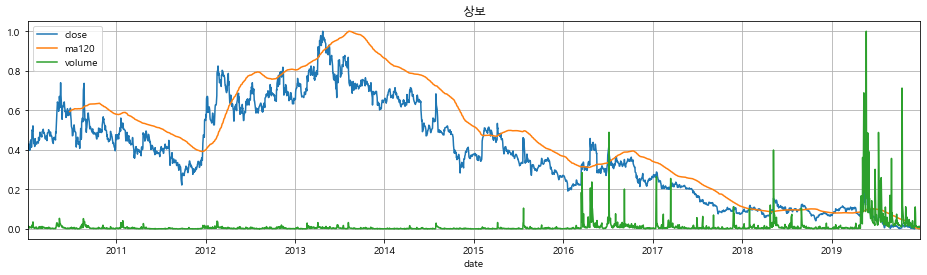

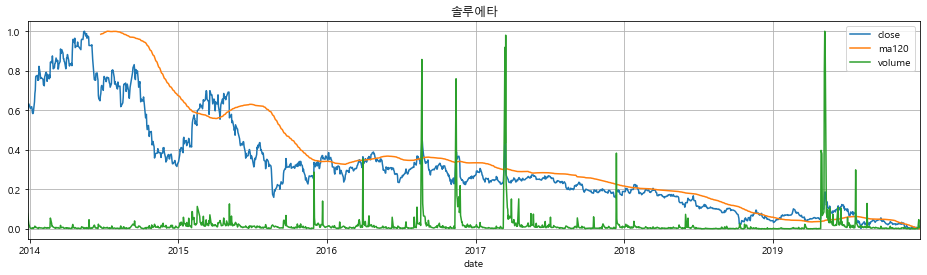

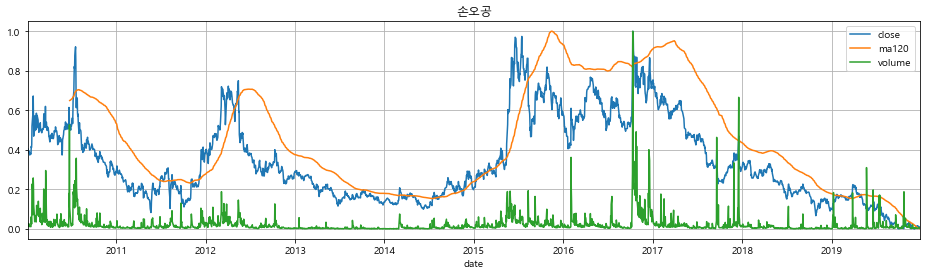

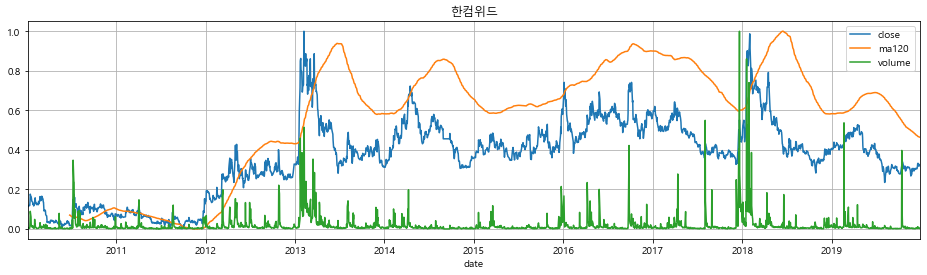

In [11]:
## 개별종목분석

from mod1 import *

name=['디엔에프','이노인스트루먼트','이에스에이','푸드나무','상보','솔루에타','손오공','한컴위드']

for i in name:
    df = select_stock(i,'2010-01-01')
    close_vol_ma(df,'ma120')

In [ ]:
##  거래량 증가 관심종목 분석

group_analysis(path_volume,'2019-09-27')

In [ ]:
##  가격 증가 관심종목 분석

group_analysis(path_price,'2019-09-30')